In [21]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda, u_met
import glob
import metpy
from metpy import calc
from metpy.units import units
from scipy import stats
import metpy
from metpy import calc
from metpy.units import units
import pickle as pkl

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [22]:
cd ..

/home/ck


In [3]:
regions = {
'RioSanta' : [(-12,-8)],
'equatorial' : [(-5,0)],
'transition' : [(-8,-5)],
'central' : [(-12,-8)],
'southern' : [(-17,-15)]}
h = 2000

In [4]:
topo_full = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/ERA5_static_hourly_0.25deg_peru.nc')
topo_full = uda.flip_lat(topo_full)

In [5]:
height = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/topo_ERA5_peru.nc')['h']


In [6]:
def readERA(var):
    
    print('Opening', glob.glob('/media/ck/Elements/SouthAmerica/ERA5/hourly/'+var+'_15UTC_1981-*_peru_*.nc')[0])
    u200orig = xr.open_dataset(glob.glob('/media/ck/Elements/SouthAmerica/ERA5/hourly/'+var+'_15UTC_1981-*_peru_*.nc')[0])
    u200orig = uda.flip_lat(u200orig)
    datetimes = pd.to_datetime(u200orig.time.values)
    newtimes = []
    for t in datetimes:
        newtimes.append(t.replace(hour=0))
    u200orig['time'] = ('time', newtimes)
    return u200orig

In [7]:
maps = readERA('v850')
maps = maps.sel(latitude=slice(-25,0), longitude=slice(-81,-55)).load()

Opening /media/ck/Elements/SouthAmerica/ERA5/hourly/v850_15UTC_1981-2019_peru_big.nc


In [8]:
mapsu = readERA('u850')
mapsu = mapsu.sel(latitude=slice(-25,0), longitude=slice(-81,-55)).load()

Opening /media/ck/Elements/SouthAmerica/ERA5/hourly/u850_15UTC_1981-2021_peru_big.nc


In [9]:
mapsq = readERA('q850')
mapsq = mapsq.sel(latitude=slice(-25,0), longitude=slice(-81,-55)).load()

Opening /media/ck/Elements/SouthAmerica/ERA5/hourly/q850_15UTC_1981-2019_peru_big.nc


In [10]:
mapsu2 = readERA('u250')
mapsu2 = mapsu2.sel(latitude=slice(-25,0), longitude=slice(-81,-55)).load()

Opening /media/ck/Elements/SouthAmerica/ERA5/hourly/u250_15UTC_1981-2018_peru_big.nc


In [11]:
mapsv2 = readERA('v250')
mapsv2 = mapsv2.sel(latitude=slice(-25,0), longitude=slice(-81,-55)).load()

Opening /media/ck/Elements/SouthAmerica/ERA5/hourly/v250_15UTC_1981-2018_peru_big.nc


In [12]:
topo = xr.open_dataarray(cnst.TOPO_1MIN).sel(lon=slice(-81,-55), lat=slice(-25,0))
height = maps.salem.lookup_transform(topo)

In [13]:
mcs = xr.open_mfdataset('/media/ck/Elements/SouthAmerica/CHIRPS/SA_daily_onERA/CHIRPS_daily_onERA_*.nc')

In [14]:
#tir = mcs['tir'].sel(time=((mcs['time.year']>=1985)&(mcs['time.year']<=2018))).sel(latitude=slice(-25,0), longitude=slice(-81,-58)).load()
tir = mcs['precip'].sel(time=((mcs['time.year']>=1985)&(mcs['time.year']<=2018))).sel(latitude=slice(-25,0), longitude=slice(-81,-58)).load()

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


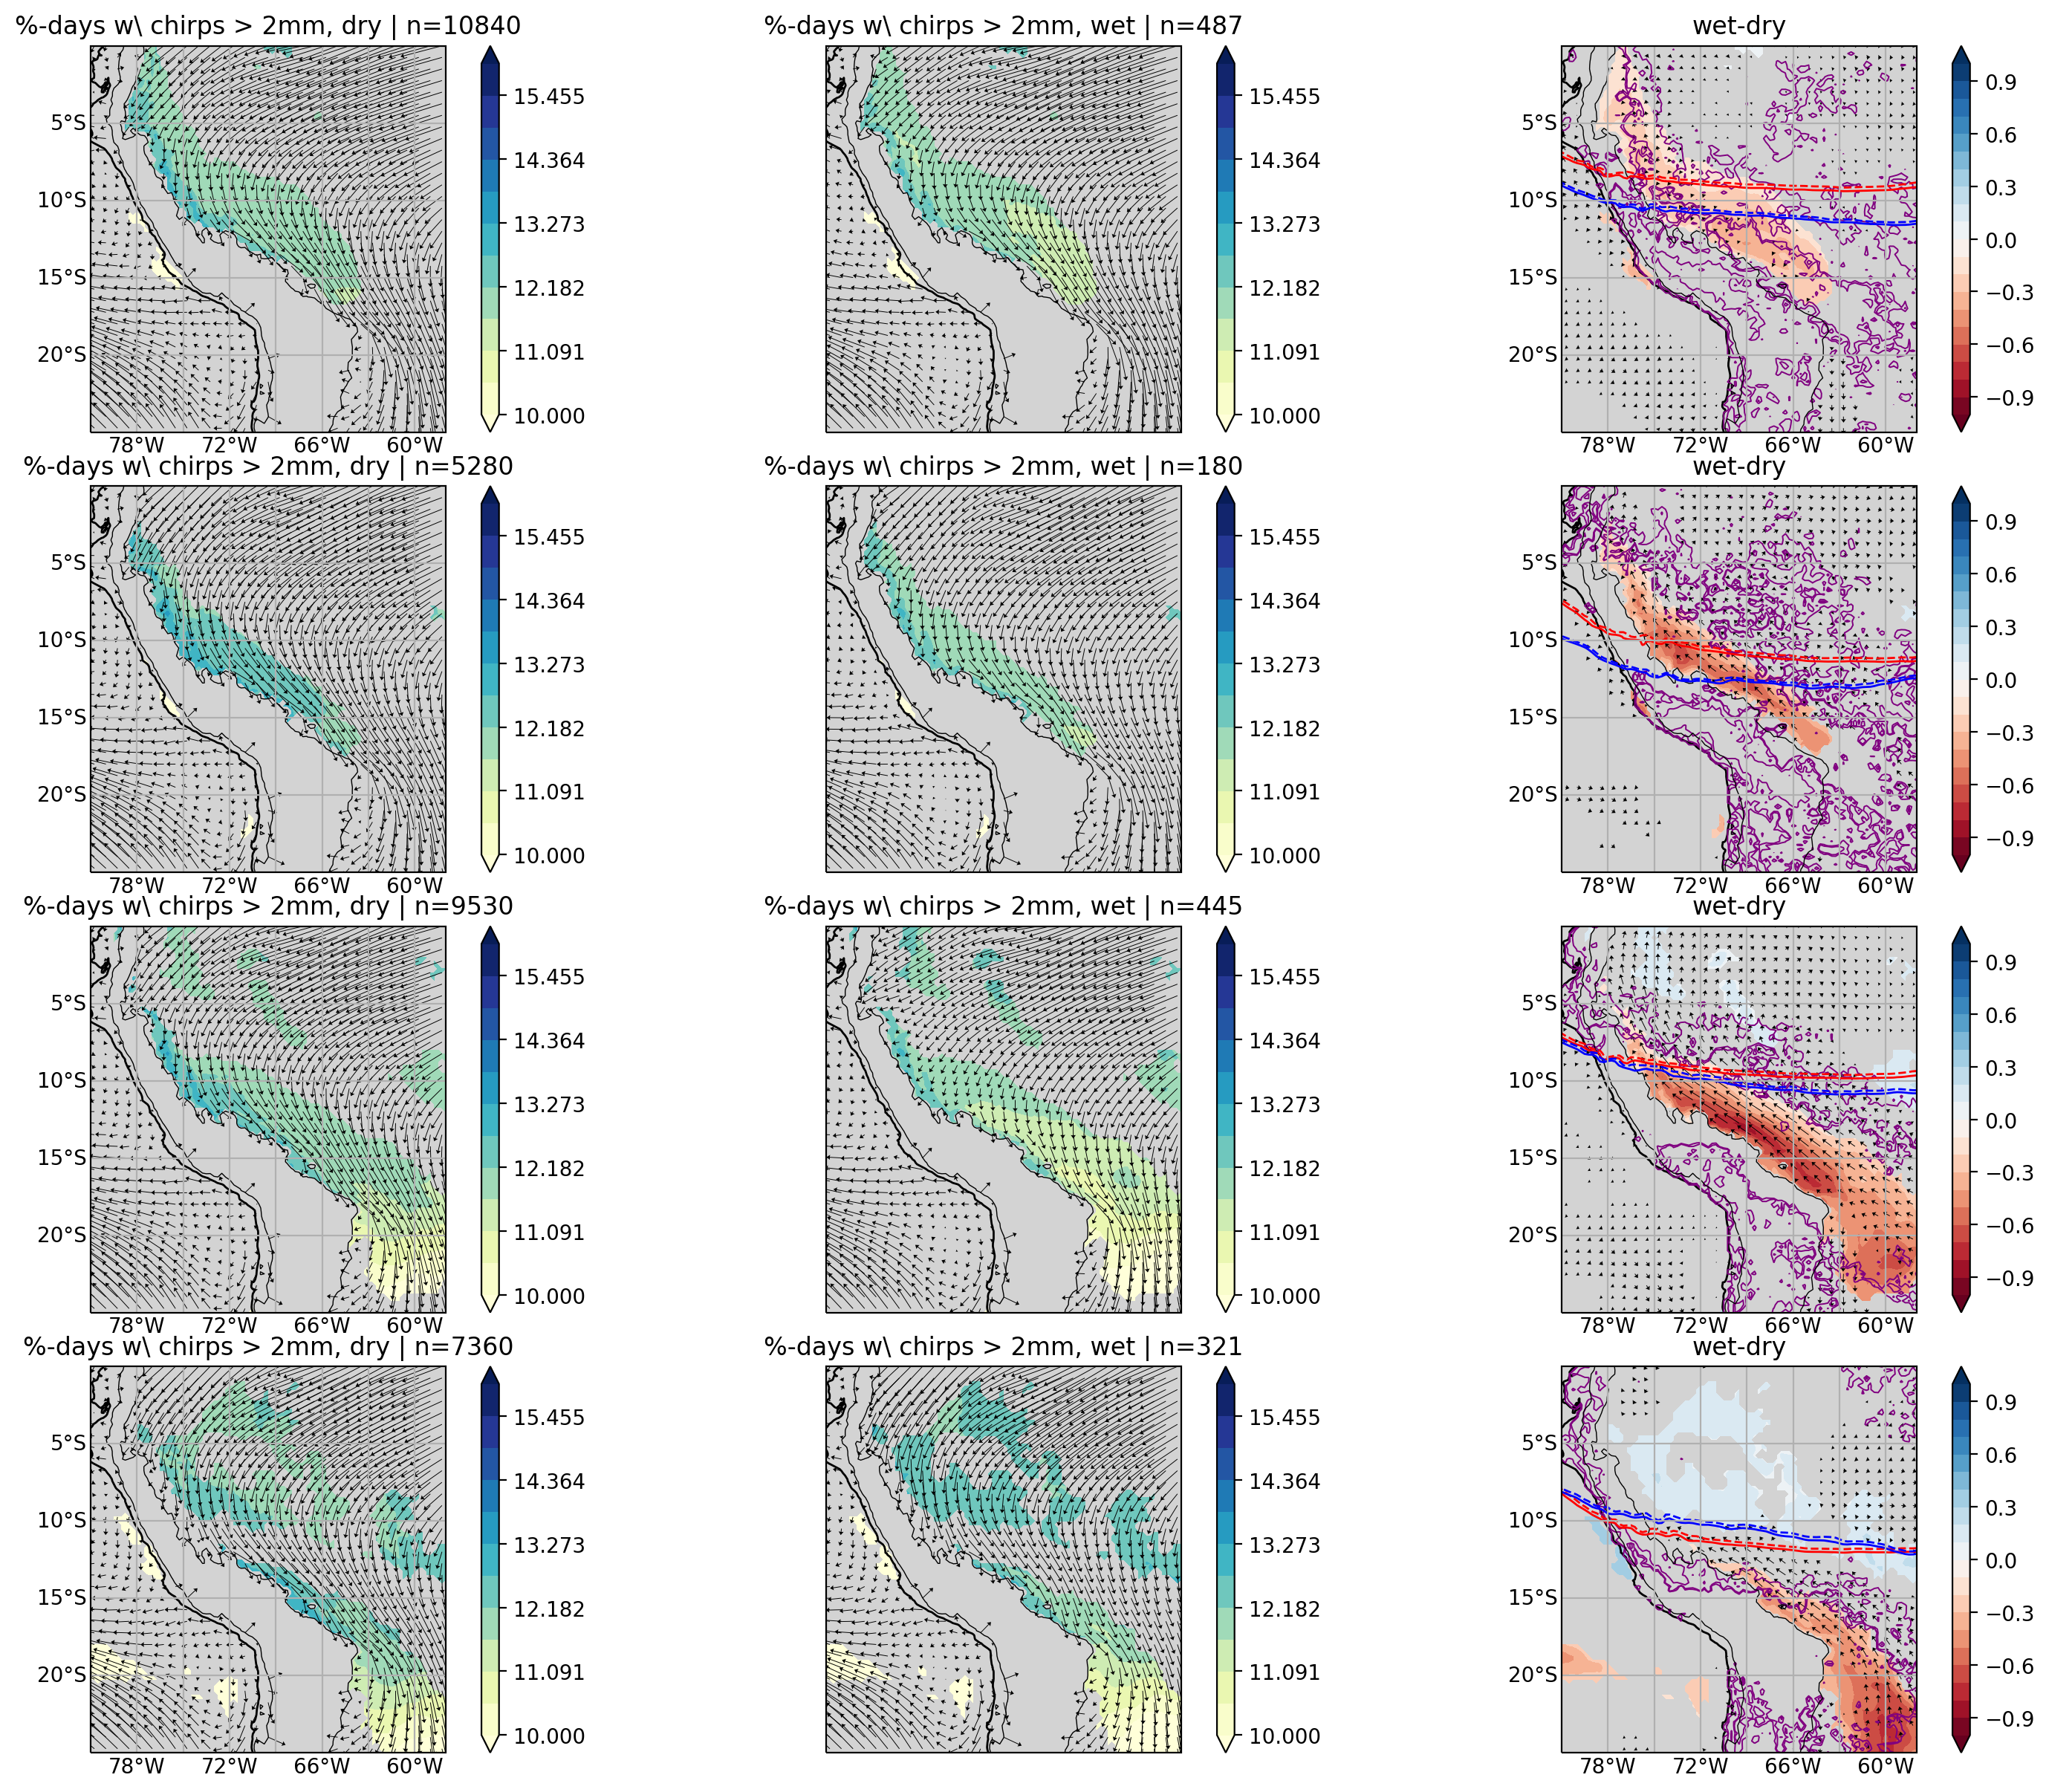

In [55]:
area = 0.15
f = plt.figure(figsize=(15,12), dpi=200)
plus = [1,2,3]
var='q'
cnt = 0

for ids, reg in enumerate(['equatorial', 'transition', 'central', 'southern']):
    
    #dic = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+reg+"_dw_spellDates_v2_1mm_fromRegional_areaCheck.p", "rb"))
    #dic = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+reg+"_dw_spellDates_"+str(area)+"perc_v2.p", "rb"))
    #dic = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+reg+"_dw_spellDates_"+str(area)+"perc_v2_split.p", "rb"))
    dic = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+reg+"_dw_spellDates_"+str(area)+"perc_v2_split.p", "rb"))

    dd = maps.sel(time=maps['time.dayofyear'].isin(dic['dry5'].dayofyear)).time #dic['dry3']#+ pd.Timedelta('1days')  #maps.sel(time=maps['time.dayofyear'].isin(dic['wet3'].dayofyear)).time #
    wd = dic['dry5']#+ pd.Timedelta('1days')
    
    drytir = np.intersect1d(maps.time.values, dd)
    wettir = np.intersect1d(maps.time.values, wd)
    
    mapsdry = maps.sel(time=dd).mean('time').where(height<1500)
    mapswet = maps.sel(time=wd).mean('time').where(height<1500)
    
    mapsdryq = mapsq['q'].sel(time=dd).mean('time').where(height<1500)
    mapswetq = mapsq['q'].sel(time=wd).mean('time').where(height<1500)
    qtstat, qpval = stats.ttest_ind(mapsq['q'].sel(time=dd), mapsq['q'].sel(time=wd), axis=0, equal_var=False)
    qmask = qpval<=0.05
    
    mapsdryu = mapsu.sel(time=dd).mean('time').where(height<1500)
    mapswetu = mapsu.sel(time=wd).mean('time').where(height<1500)
    utstat, upval = stats.ttest_ind(mapsu.sel(time=dd)['u'], mapsu.sel(time=wd)['u'], axis=0, equal_var=False)
    umask = upval<=0.05
    
    wtstat, wpval = stats.ttest_ind(maps.sel(time=dd)['v'], maps.sel(time=wd)['v'], axis=0, equal_var=False)
    wmask = wpval<=0.05
    
    
    mapsdryu2 = mapsu2.sel(time=dd).mean('time') #-pd.Timedelta('1days')
    mapswetu2 = mapsu2.sel(time=wd).mean('time') #-pd.Timedelta('1days')
#     mapsdryv2 = mapsv2.sel(time=dd).mean('time') #-pd.Timedelta('1days')
#     mapswetv2 = mapsv2.sel(time=wd).mean('time') #-pd.Timedelta('1days')

    dryti = np.intersect1d(tir.time.values, dd)
    wetti = np.intersect1d(tir.time.values, wd)
    
    tirdry = tir.where(tir>1).sel(time=dryti).count('time')/len(drytir)*100
    tirwet = tir.where(tir>1).sel(time=wetti).count('time')/len(wettir)*100
    
    uanodry = mapsdryu['u']
    vanodry = mapsdry['v'] # multiplied by 10 since vertical component is very small compared to horizontal one
    uanowet = mapswetu['u']
    vanowet = mapswet['v']
    st=3
    sarrow = 1
    xquiv = mapsdryu.longitude[sarrow::st]
    yquiv = mapsdryu.latitude[sarrow::st]

    uud = (uanodry)[sarrow::st, sarrow::st]  
    vvd = (vanodry)[sarrow::st, sarrow::st]

    uuw = (uanowet)[sarrow::st, sarrow::st]  
    vvw = (vanowet)[sarrow::st, sarrow::st]
    
    bothmask = umask[sarrow::st, sarrow::st] | wmask[sarrow::st, sarrow::st] 
   # ipdb.set_trace()
 

    ax = f.add_subplot(4,3,(ids+1)+cnt, projection=ccrs.PlateCarree())
    ax.set_facecolor('lightgrey')

    ax.coastlines()
            # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.top_labels = False
    xl.right_labels = False

    plt.contourf(mapsdry.longitude, mapsdry.latitude,mapsdryq.where(qmask)*1000, levels=np.linspace(10,16,12), cmap='YlGnBu', transform=ccrs.PlateCarree(), extend='both')
    plt.colorbar()
    plt.contour(height.longitude, height.latitude, height, levels=[-5,1500], colors='k', linewidths=0.5)
    plt.quiver(xquiv, yquiv, uud, vvd, scale=55, width=0.002, headwidth=7)
    ax.set_xlim(-81,-58)
    ax.set_ylim(-25,0)
    plt.title('%-days w\ chirps > 2mm, dry | n='+str(len(dd)))

    ax = f.add_subplot(4,3,ids+2+cnt, projection=ccrs.PlateCarree())
    ax.set_facecolor('lightgrey')
    ax.coastlines()
    plt.contourf(mapswet.longitude, mapsdry.latitude, mapswetq.where(qmask)*1000, levels=np.linspace(10,16,12), cmap='YlGnBu', transform=ccrs.PlateCarree(), extend='both')
    plt.colorbar()
    plt.contour(height.longitude, height.latitude, height, levels=[-5,1500], colors='k', linewidths=0.5)
    plt.quiver(xquiv, yquiv, uuw, vvw, scale=55, width=0.002, headwidth=7)
    xl.top_labels = False
    xl.right_labels = False
    ax.set_xlim(-81,-58)
    ax.set_ylim(-25,0)
    plt.title('%-days w\ chirps > 2mm, wet | n='+str(len(wd)))

    ax = f.add_subplot(4,3,ids+3+cnt, projection=ccrs.PlateCarree())
    ax.set_facecolor('lightgrey')
    ax.coastlines()
    plt.contourf(mapswet.longitude, mapsdry.latitude, (mapswetq-mapsdryq).where(qmask)*1000, levels=np.arange(-1,1.1,0.1),cmap='RdBu', transform=ccrs.PlateCarree(), extend='both')
    plt.colorbar()
    plt.contour(tirwet.longitude, tirwet.latitude, (tirwet-tirdry), levels=[0,1,5], colors=['purple'] , transform=ccrs.PlateCarree(), extend='both', linewidths=0.7)
    
    plt.contour(height.longitude, height.latitude, height, levels=[-5,1500], colors='k', linewidths=0.5)
    plt.contour(mapswet.longitude, mapsdry.latitude,mapsdryu2['u'], levels=[-0.1,0.1], colors='r', linewidths=1)
    plt.contour(mapswet.longitude, mapsdry.latitude,mapswetu2['u'], levels=[-0.1,0.1], colors='b', linewidths=1)
    plt.quiver(xquiv, yquiv, (uuw-uud).where(bothmask), (vvw-vvd).where(bothmask), scale=55, width=0.002, headwidth=7)
    xl = ax.gridlines(draw_labels=True);
    xl.top_labels = False
    xl.right_labels = False
    ax.set_xlim(-81,-58)
    ax.set_ylim(-25,0)
    plt.title('wet-dry')
    
    cnt +=2

    plt.tight_layout()
    #f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/paper/correlations/drywet/gridsat_3days_day0_'+pregion+'.jpg')

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:130: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


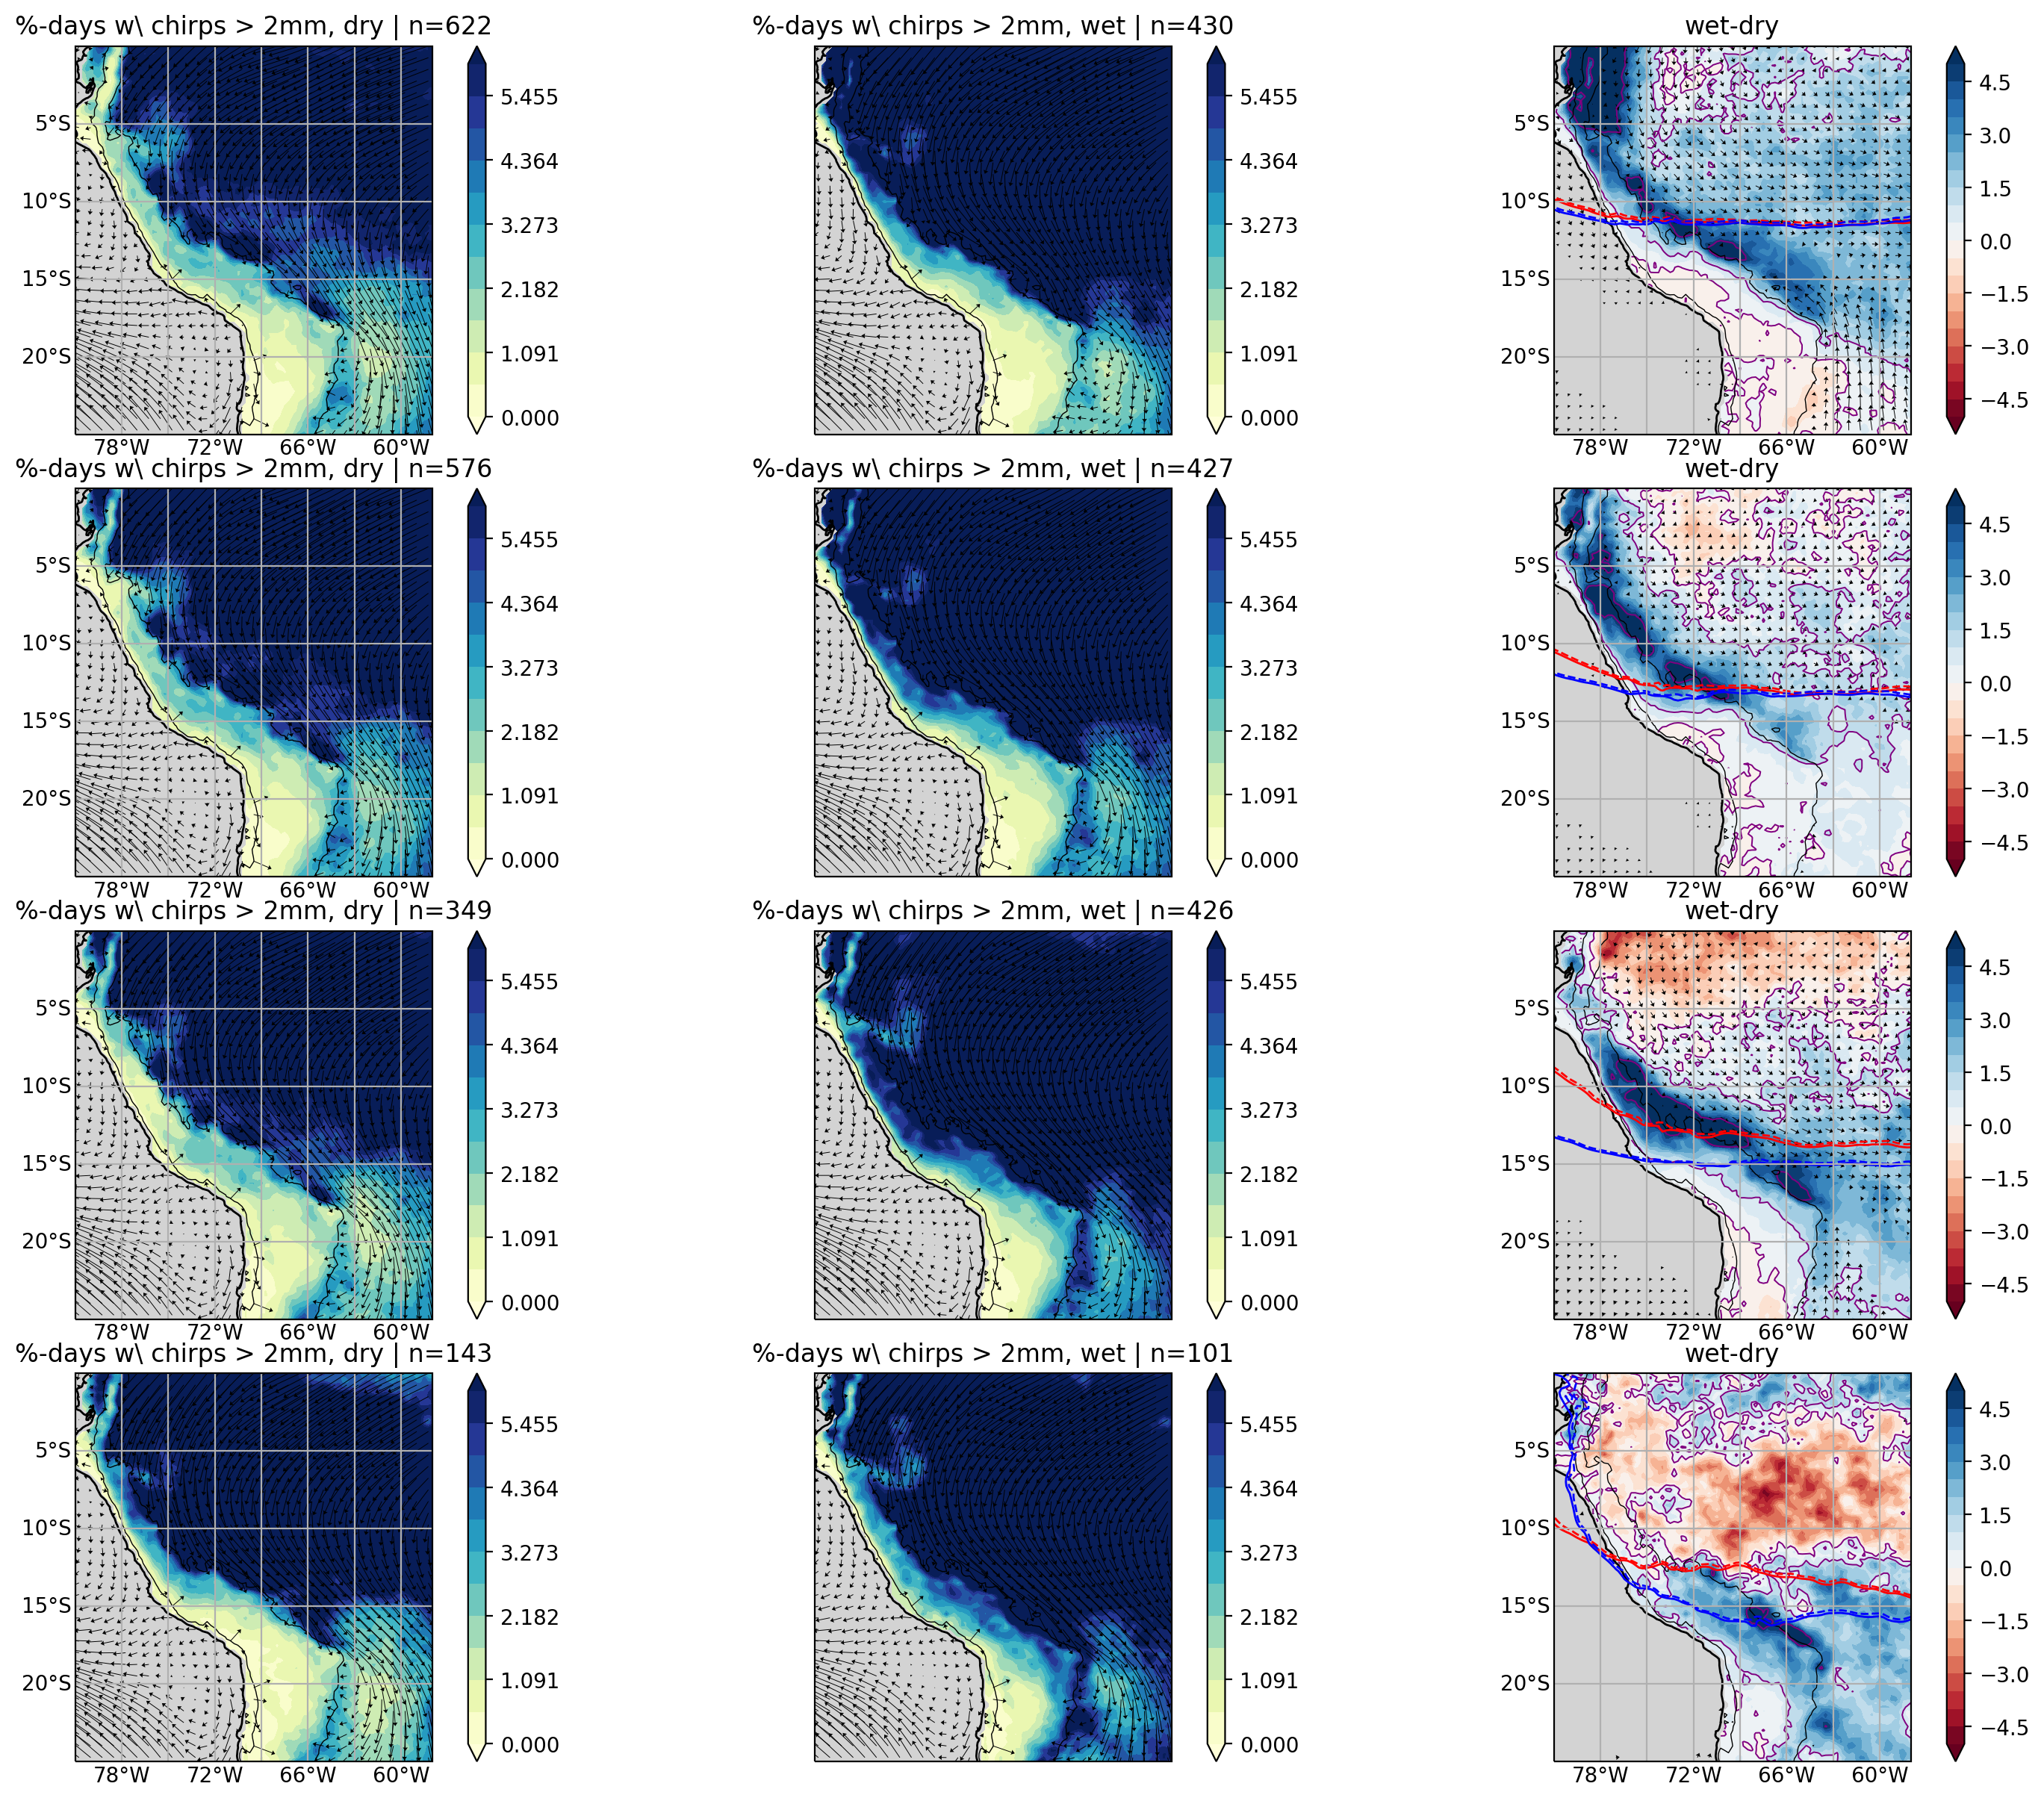

In [46]:
area = 0.15
f = plt.figure(figsize=(15,12), dpi=200)
plus = [1,2,3]
var='q'
cnt = 0

for ids, reg in enumerate(['equatorial', 'transition', 'central', 'southern']):
    
#     if reg == 'transition':
#         area=0.2
#     else:
    area=0.15
    
    #dic = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+reg+"_dw_spellDates_v2_fromRegional_areaCheck.p", "rb"))
    dic = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+reg+"_dw_spellDates_"+str(area)+"perc_v2.p", "rb"))

    dd = dic['dry3']#+ pd.Timedelta('1days')
    wd = dic['wet3']#+ pd.Timedelta('1days')
    
    drytirclim = np.intersect1d(tir['time.dayofyear'].values, dd.dayofyear.values)
    wetirclim = np.intersect1d(tir['time.dayofyear'].values, wd.dayofyear.values)
    
    
    drytir = np.intersect1d(maps.time.values, dd)
    wettir = np.intersect1d(maps.time.values, wd)
    
    mapsdry = maps.sel(time=maps['time.dayofyear'].isin(wetirclim)).mean('time').where(height<1500)   #dd
    mapswet = maps.sel(time=wd).mean('time').where(height<1500)
    
    mapsdryq = mapsq['q'].sel(time=mapsq['time.dayofyear'].isin(wetirclim)).mean('time')#.where(height<1500) #dd
    mapswetq = mapsq['q'].sel(time=wd).mean('time')#.where(height<1500)
    qtstat, qpval = stats.ttest_ind(mapsq['q'].sel(time=mapsq['time.dayofyear'].isin(wetirclim)), mapsq['q'].sel(time=wd), axis=0, equal_var=False) #dd
    qmask = qpval<=0.05
    
    mapsdryu = mapsu.sel(time=maps['time.dayofyear'].isin(wetirclim)).mean('time').where(height<1500) #dd
    mapswetu = mapsu.sel(time=wd).mean('time').where(height<1500)
    utstat, upval = stats.ttest_ind(mapsu.sel(time=mapsu['time.dayofyear'].isin(wetirclim))['u'], mapsu.sel(time=wd)['u'], axis=0, equal_var=False) #dd
    umask = upval<=0.05
    
    wtstat, wpval = stats.ttest_ind(maps.sel(time=maps['time.dayofyear'].isin(wetirclim))['v'], maps.sel(time=wd)['v'], axis=0, equal_var=False) #dd
    wmask = wpval<=0.05
    
    
    mapsdryu2 = mapsu2.sel(time=dd).mean('time') #-pd.Timedelta('1days')  #dd
    mapswetu2 = mapsu2.sel(time=wd).mean('time') #-pd.Timedelta('1days')
#     mapsdryv2 = mapsv2.sel(time=dd).mean('time') #-pd.Timedelta('1days')
#     mapswetv2 = mapsv2.sel(time=wd).mean('time') #-pd.Timedelta('1days')

    dryti = np.intersect1d(tir.time.values, dd)
    wetti = np.intersect1d(tir.time.values, wd)
    

  #  ipdb.set_trace()
    
    tirdry = tir.sel(time=dryti).mean('time')
    tirwet = tir.sel(time=wetti).mean('time')
    
    tirdryclim = tir.sel(time=tir['time.dayofyear'].isin(drytirclim)).mean('time')
    tirwetclim = tir.sel(time=tir['time.dayofyear'].isin(wetirclim)).mean('time')
    
    uanodry = mapsdryu['u']
    vanodry = mapsdry['v'] # multiplied by 10 since vertical component is very small compared to horizontal one
    uanowet = mapswetu['u']
    vanowet = mapswet['v']
    st=3
    sarrow = 1
    xquiv = mapsdryu.longitude[sarrow::st]
    yquiv = mapsdryu.latitude[sarrow::st]

    uud = (uanodry)[sarrow::st, sarrow::st]  
    vvd = (vanodry)[sarrow::st, sarrow::st]

    uuw = (uanowet)[sarrow::st, sarrow::st]  
    vvw = (vanowet)[sarrow::st, sarrow::st]
    
    bothmask = umask[sarrow::st, sarrow::st] | wmask[sarrow::st, sarrow::st] 
   # ipdb.set_trace()
 

    ax = f.add_subplot(4,3,(ids+1)+cnt, projection=ccrs.PlateCarree())
    ax.set_facecolor('lightgrey')

    ax.coastlines()
            # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.top_labels = False
    xl.right_labels = False

    plt.contourf(mapsdry.longitude, mapsdry.latitude,tirdry, levels=np.linspace(0,6,12), cmap='YlGnBu', transform=ccrs.PlateCarree(), extend='both')
    plt.colorbar()
    plt.contour(height.longitude, height.latitude, height, levels=[-5,1500], colors='k', linewidths=0.5)
    plt.quiver(xquiv, yquiv, uud, vvd, scale=55, width=0.002, headwidth=7)
    ax.set_xlim(-81,-58)
    ax.set_ylim(-25,0)
    plt.title('%-days w\ chirps > 2mm, dry | n='+str(len(dd)))

    ax = f.add_subplot(4,3,ids+2+cnt, projection=ccrs.PlateCarree())
    ax.set_facecolor('lightgrey')
    ax.coastlines()
    plt.contourf(mapswet.longitude, mapsdry.latitude, tirwet, levels=np.linspace(0,6,12), cmap='YlGnBu', transform=ccrs.PlateCarree(), extend='both')
    plt.colorbar()
    plt.contour(height.longitude, height.latitude, height, levels=[-5,1500], colors='k', linewidths=0.5)
    plt.quiver(xquiv, yquiv, uuw, vvw, scale=55, width=0.002, headwidth=7)
    xl.top_labels = False
    xl.right_labels = False
    ax.set_xlim(-81,-58)
    ax.set_ylim(-25,0)
    plt.title('%-days w\ chirps > 2mm, wet | n='+str(len(wd)))

    ax = f.add_subplot(4,3,ids+3+cnt, projection=ccrs.PlateCarree())
    ax.set_facecolor('lightgrey')
    ax.coastlines()
    plt.contourf(mapswet.longitude, mapsdry.latitude, (tirwet-tirdry), levels=np.arange(-5,5.1,0.5),cmap='RdBu', transform=ccrs.PlateCarree(), extend='both')
    plt.colorbar()
    plt.contour(tirwet.longitude, tirwet.latitude, (tirwet-tirdry), levels=[0,1,5], colors=['purple'] , transform=ccrs.PlateCarree(), extend='both', linewidths=0.7)
    
    plt.contour(height.longitude, height.latitude, height, levels=[-5,1500], colors='k', linewidths=0.5)
    plt.contour(mapswet.longitude, mapsdry.latitude,mapsdryu2['u'], levels=[-0.1,0.1], colors='r', linewidths=1)
    plt.contour(mapswet.longitude, mapsdry.latitude,mapswetu2['u'], levels=[-0.1,0.1], colors='b', linewidths=1)
    plt.quiver(xquiv, yquiv, (uuw-uud).where(bothmask), (vvw-vvd).where(bothmask), scale=55, width=0.002, headwidth=7)
    xl = ax.gridlines(draw_labels=True);
    xl.top_labels = False
    xl.right_labels = False
    ax.set_xlim(-81,-58)
    ax.set_ylim(-25,0)
    plt.title('wet-dry')
    
    cnt +=2

    plt.tight_layout()
    #f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/paper/correlations/drywet/gridsat_3days_day0_'+pregion+'.jpg')